In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'NDA.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2007-12-31,1423,-1308,115,50,86,194,1072,1571,0,...,2226,302,0,148,759,154,1154,-9,-18,40.87
1,2008-03-31,1983,-1843,140,60,140,522,1794,2903,0,...,3858,836,0,432,1796,596,2785,257,-25,40.87
2,2008-06-30,2633,-2459,174,61,41,519,1923,2925,0,...,3888,854,0,496,1810,558,2751,-82,-29,40.87
3,2008-09-30,2408,-2306,102,-1,187,391,1402,2292,0,...,3249,444,0,410,1254,523,2113,290,-44,40.87
4,2008-12-31,1501,-1777,-277,-257,108,316,947,1895,0,...,2917,389,0,275,1274,530,2039,150,-87,40.87


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
60,2022-12-31,2023-02-11,43.66,4096,-3968,128,57,540,902,3898,...,0,7515,1796,0,94,2237,167,3195,-64,-71
61,2023-03-31,2023-04-21,43.66,4688,-4464,224,106,451,795,4065,...,143,7747,1975,0,95,2408,167,3438,83,-104
62,2023-06-30,2023-07-21,43.66,4167,-4065,102,4,243,836,3907,...,0,7323,1656,0,33,1987,167,3009,54,-193
63,2023-09-30,2023-10-21,43.66,4113,-4038,74,-26,494,563,3399,...,143,7260,1566,0,58,1992,167,3015,500,-257
64,2023-12-31,2024-02-11,43.61,3896,-3715,181,58,134,735,3690,...,0,7155,1452,0,43,1850,167,2871,-202,-151


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
60,2022-12-31,2023-02-11,43.66,4096,-3968,128,57,540,902,3898,...,7515,1796,0,94,2237,167,3195,-64,-71,0.980663
61,2023-03-31,2023-04-21,43.66,4688,-4464,224,106,451,795,4065,...,7747,1975,0,95,2408,167,3438,83,-104,0.932003
62,2023-06-30,2023-07-21,43.66,4167,-4065,102,4,243,836,3907,...,7323,1656,0,33,1987,167,3009,54,-193,0.918362
63,2023-09-30,2023-10-21,43.66,4113,-4038,74,-26,494,563,3399,...,7260,1566,0,58,1992,167,3015,500,-257,0.918837
64,2023-12-31,2024-02-11,43.61,3896,-3715,181,58,134,735,3690,...,7155,1452,0,43,1850,167,2871,-202,-151,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
60,2022-12-31,2023-02-11,43.66,4096,-3968,128,57,540,902,3898,...,7515,1796,0,94,2237,167,3195,-64,-71,0.980663
61,2023-03-31,2023-04-21,43.66,4688,-4464,224,106,451,795,4065,...,7747,1975,0,95,2408,167,3438,83,-104,0.932003
62,2023-06-30,2023-07-21,43.66,4167,-4065,102,4,243,836,3907,...,7323,1656,0,33,1987,167,3009,54,-193,0.918362
63,2023-09-30,2023-10-21,43.66,4113,-4038,74,-26,494,563,3399,...,7260,1566,0,58,1992,167,3015,500,-257,0.918837
64,2023-12-31,2024-02-11,43.61,3896,-3715,181,58,134,735,3690,...,7155,1452,0,43,1850,167,2871,-202,-151,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2008-02-11,18.157631,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,0.481581,0.518419,29.340206,17.324503,66.186047,4.880597,0.080815,0.035137,0.089847,0.186567
1,2008-02-18,17.163872,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,0.481581,0.518419,29.340206,17.324503,66.186047,4.880597,0.080815,0.035137,0.089847,0.186567
2,2008-02-25,16.286659,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,0.481581,0.518419,29.340206,17.324503,66.186047,4.880597,0.080815,0.035137,0.089847,0.186567
3,2008-03-03,15.016853,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,0.481581,0.518419,29.340206,17.324503,66.186047,4.880597,0.080815,0.035137,0.089847,0.186567
4,2008-03-10,16.020626,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,0.481581,0.518419,29.340206,17.324503,66.186047,4.880597,0.080815,0.035137,0.089847,0.186567


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2008-02-11,18.157631,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,4.880597,0.080815,0.035137,0.089847,0.186567,3.710512,0.692260,0.130376,0.318008,20.613955
1,2008-02-18,17.163872,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,4.880597,0.080815,0.035137,0.089847,0.186567,3.507437,0.654373,0.123241,0.310873,19.485762
2,2008-02-25,16.286659,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,4.880597,0.080815,0.035137,0.089847,0.186567,3.328179,0.620929,0.116942,0.304574,18.489882
3,2008-03-03,15.016853,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,4.880597,0.080815,0.035137,0.089847,0.186567,3.068694,0.572518,0.107825,0.295457,17.048300
4,2008-03-10,16.020626,2007-12-31,1423.0,4.893565,26.229508,40.87,36.0,0.880842,86.0,...,4.880597,0.080815,0.035137,0.089847,0.186567,3.273815,0.610786,0.115032,0.302664,18.187861


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

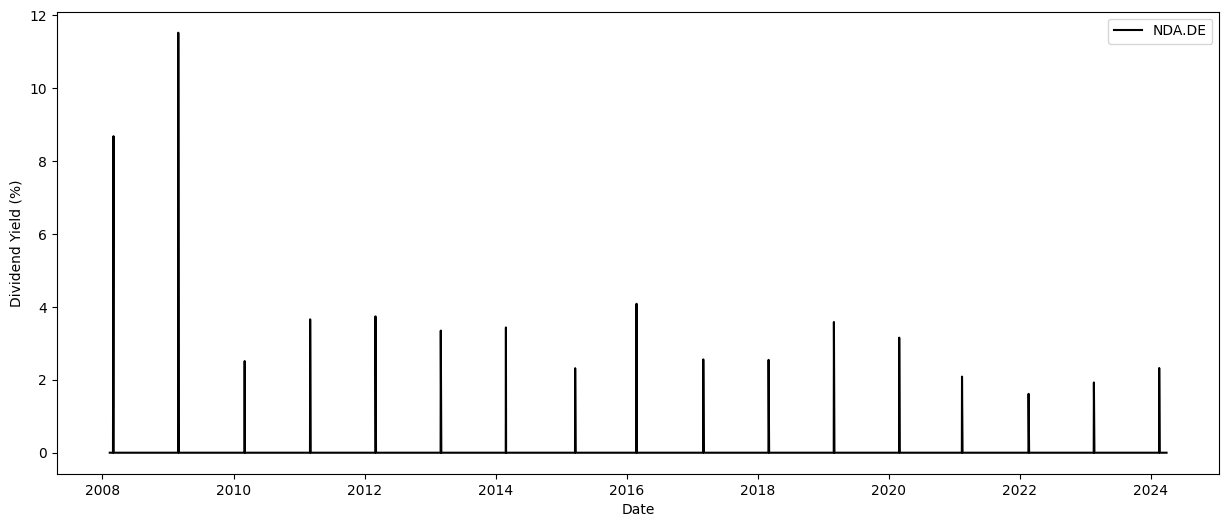

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.669605
share_price      1.000000
Name: share_price, dtype: float64


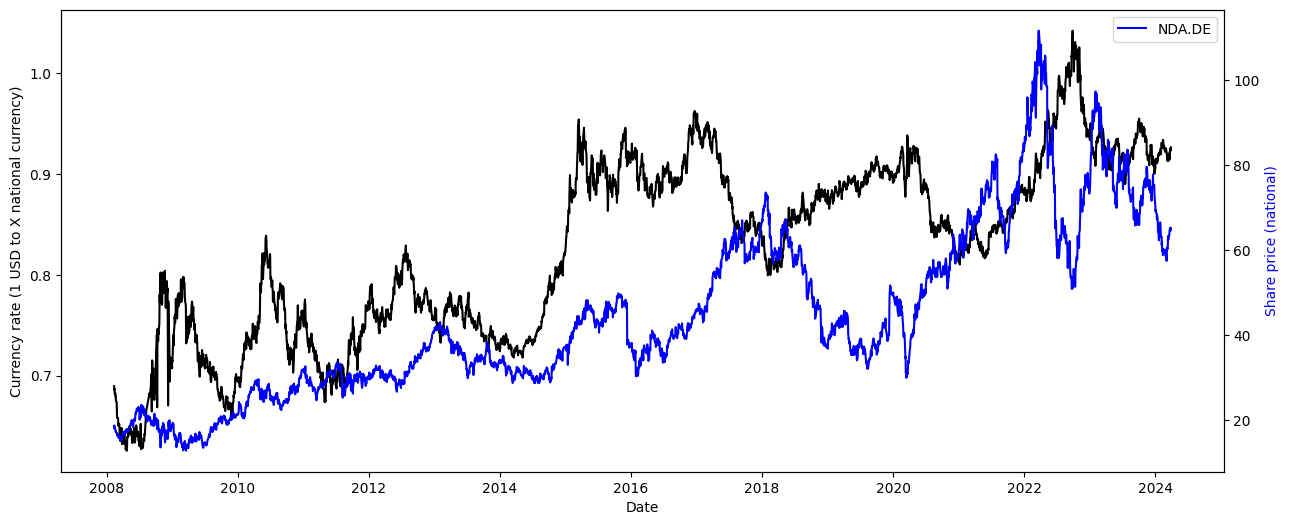

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

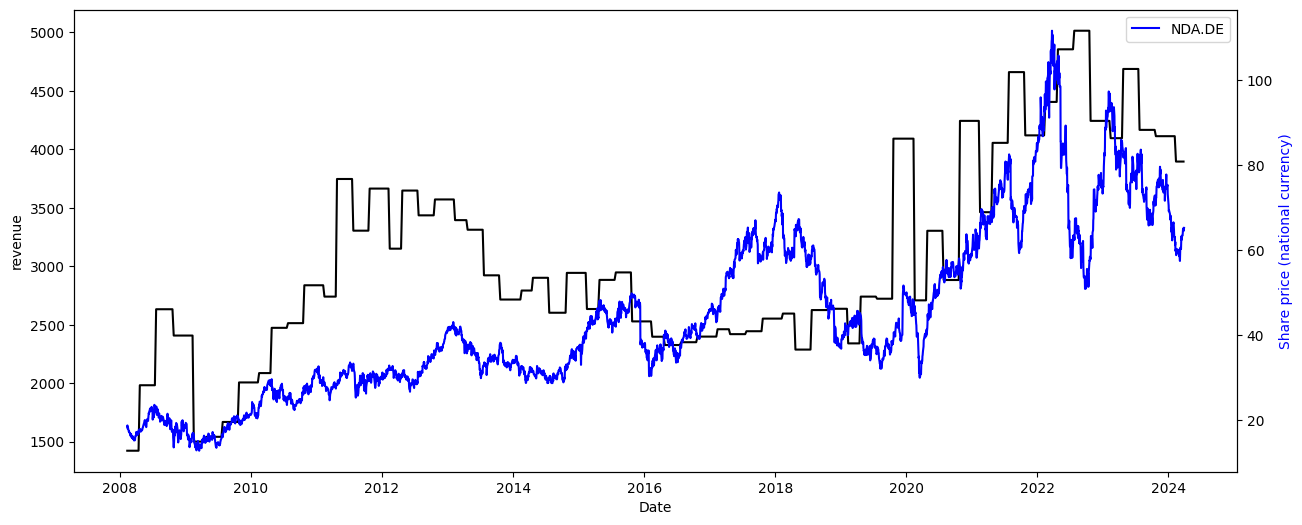

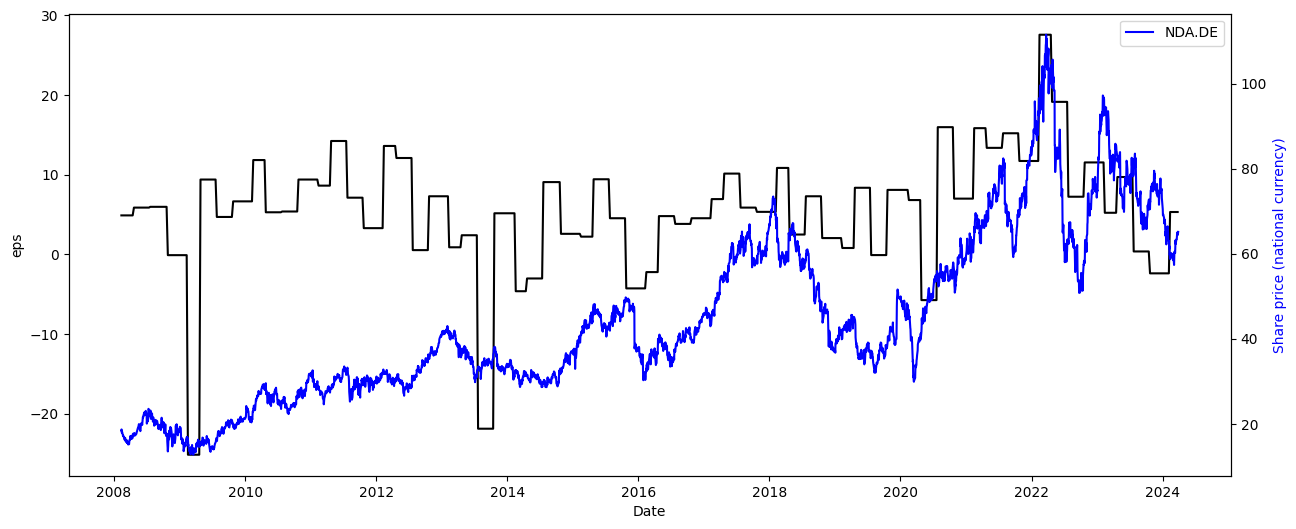

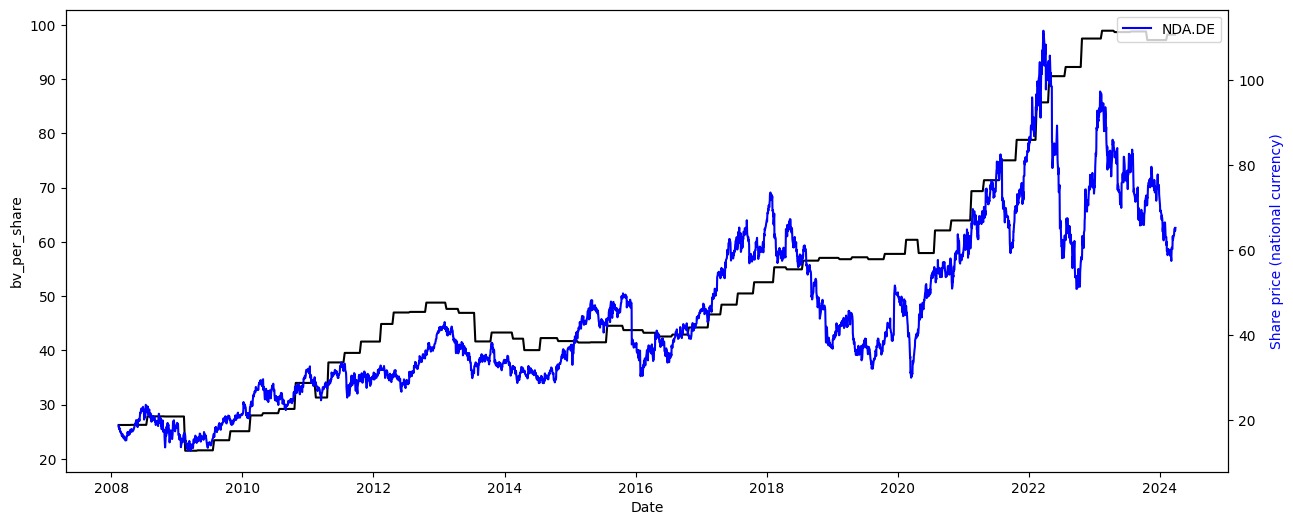

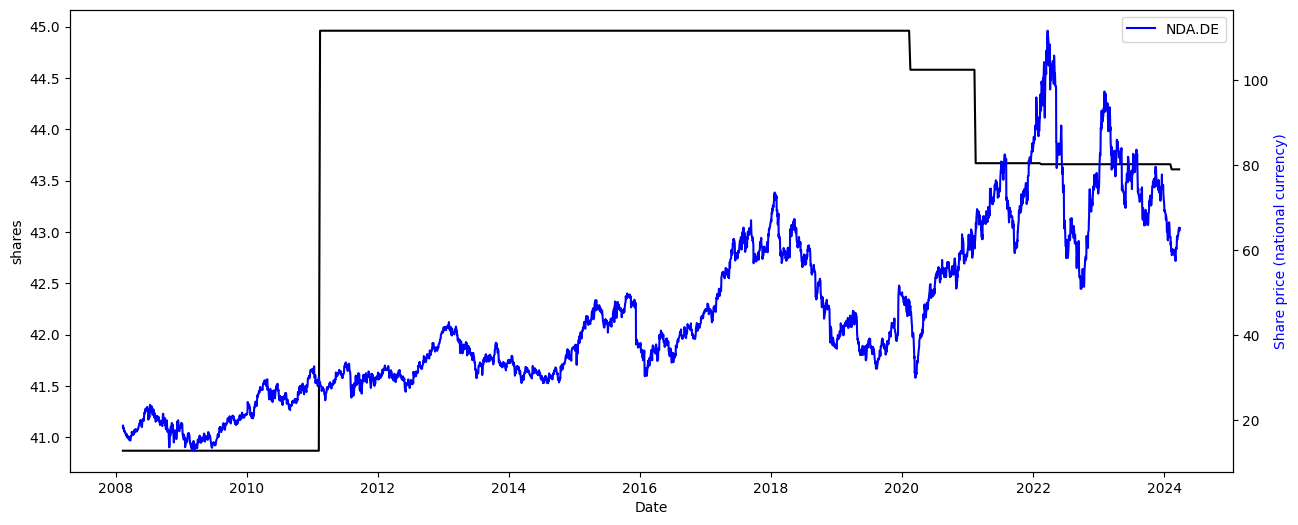

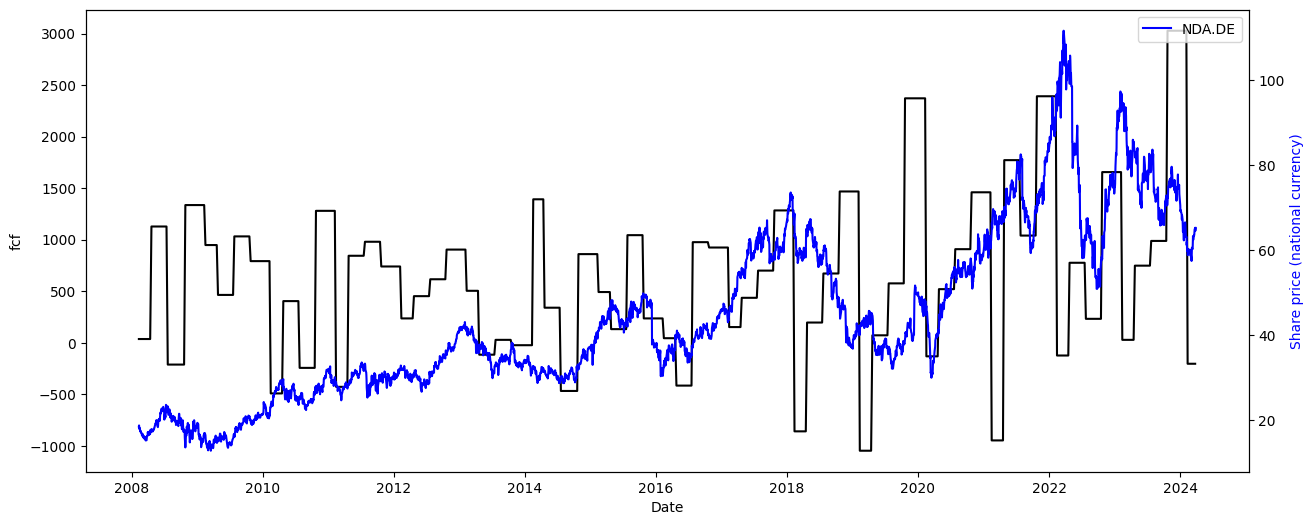

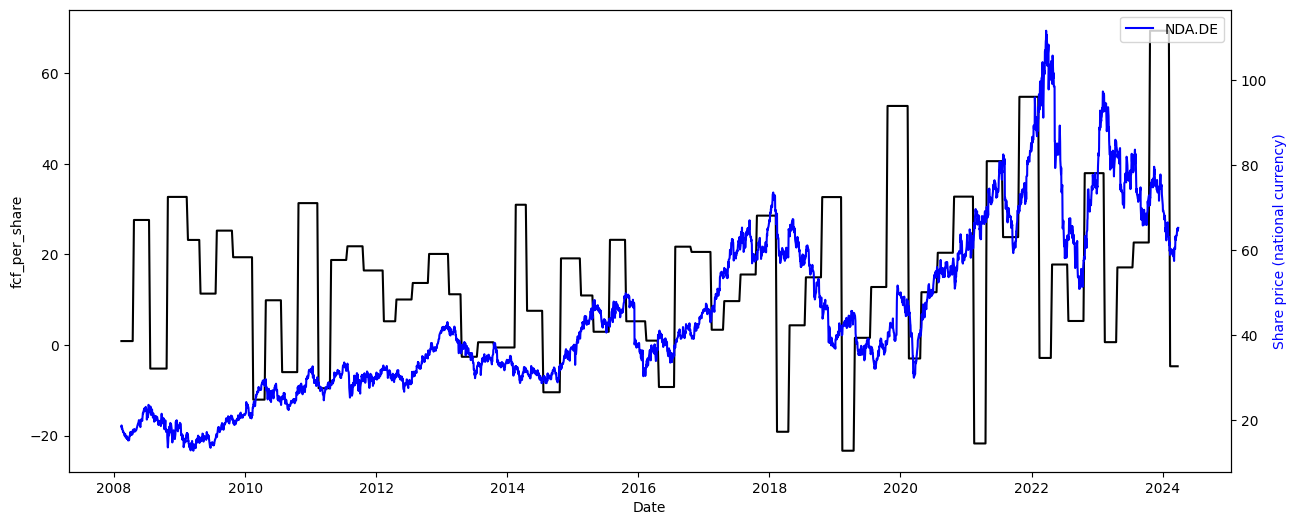

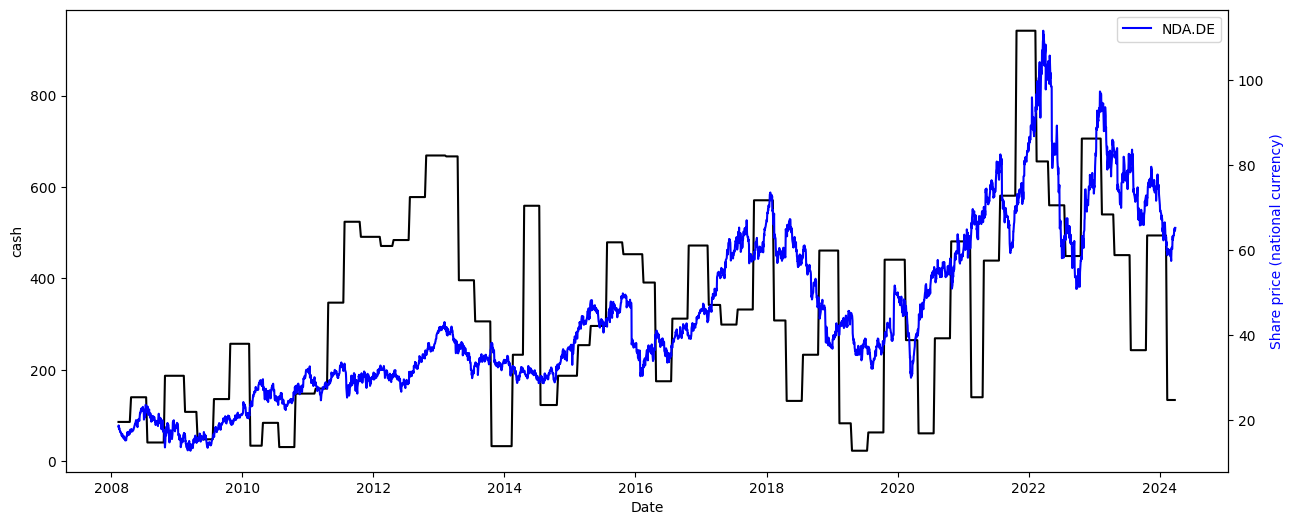

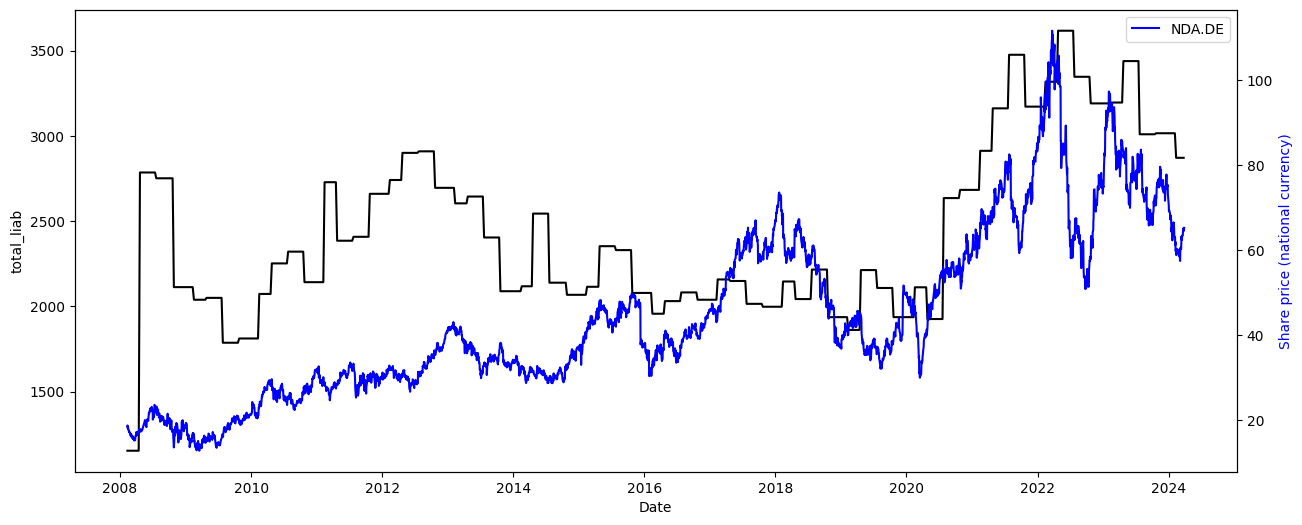

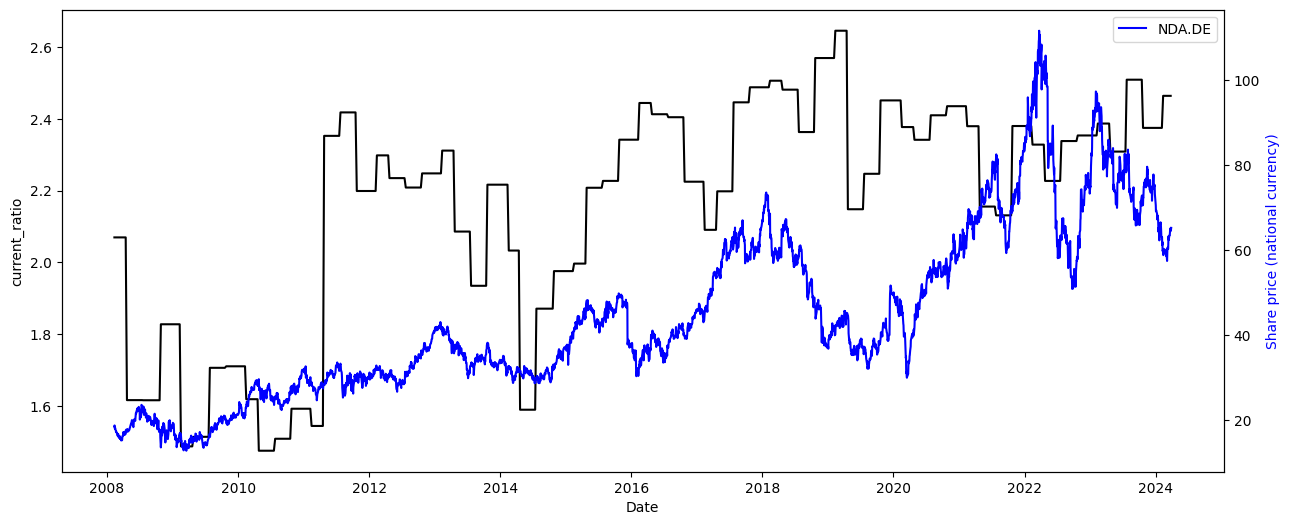

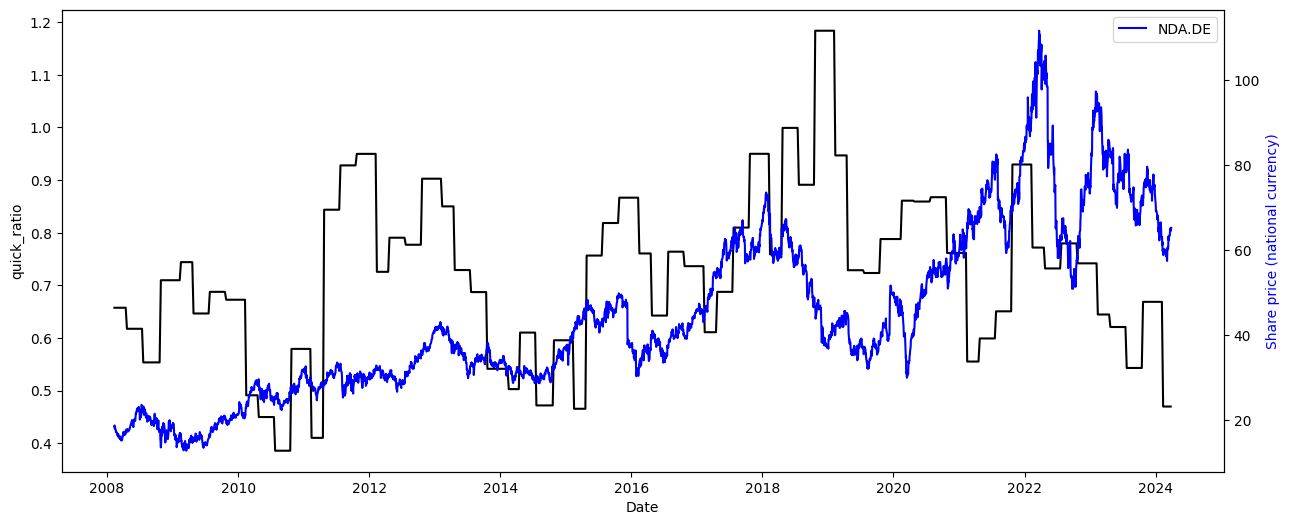

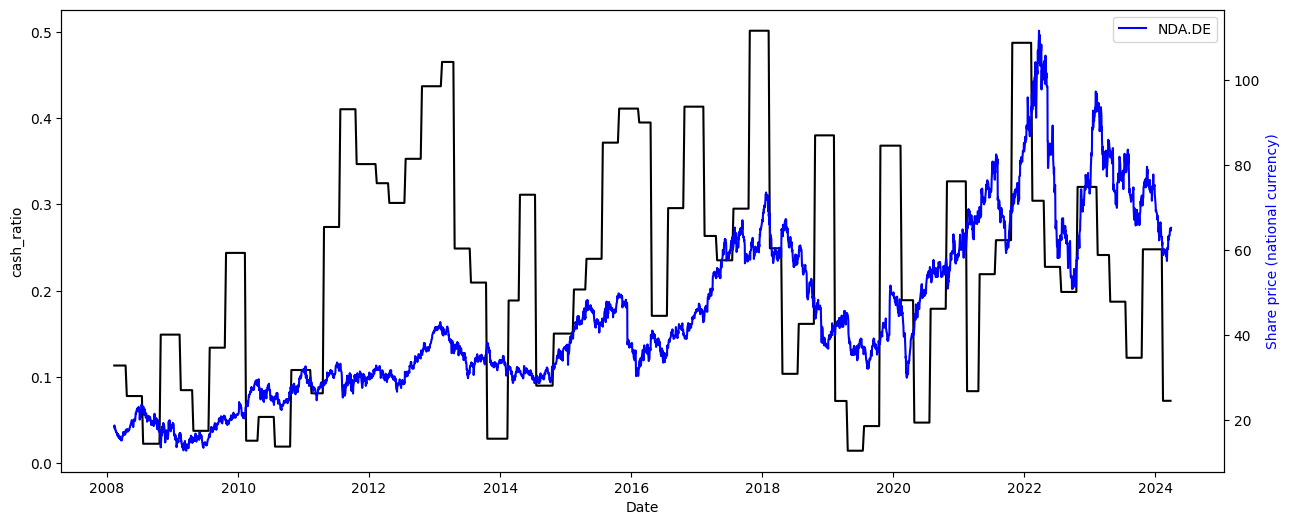

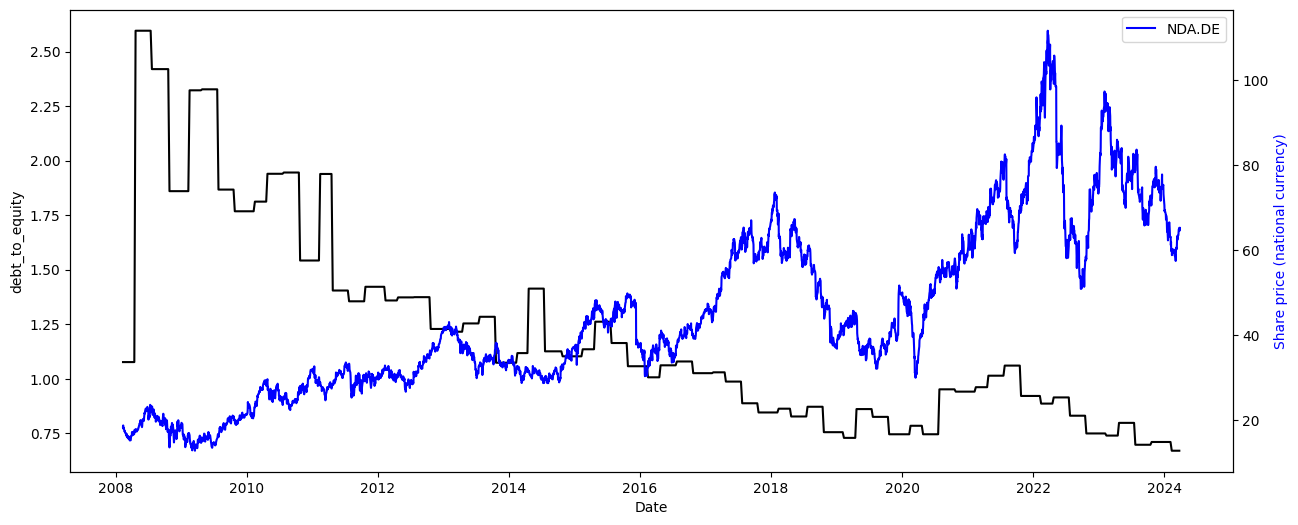

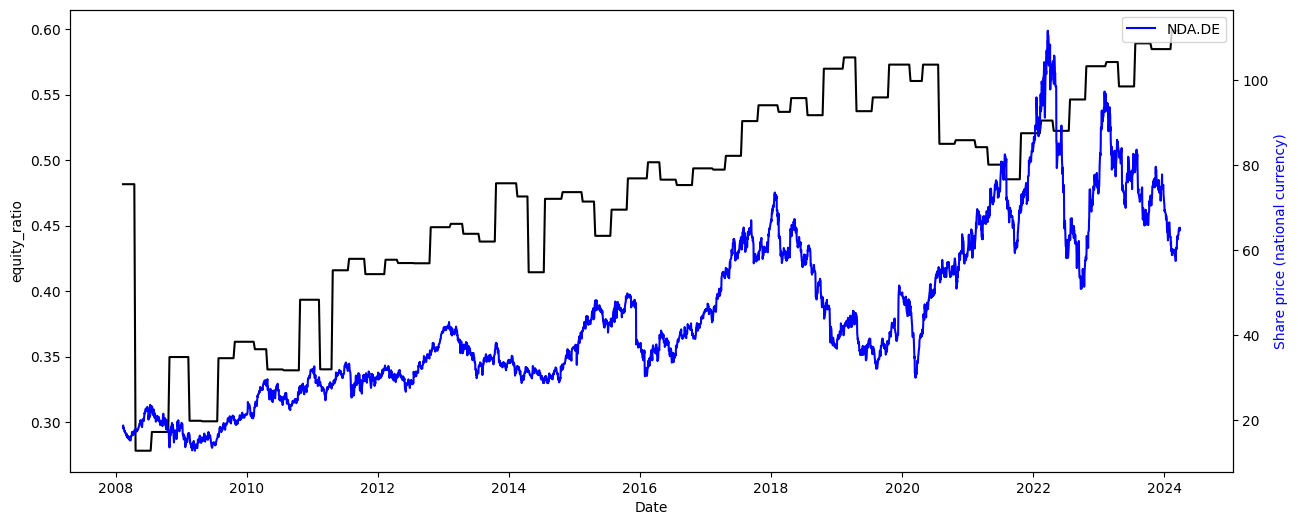

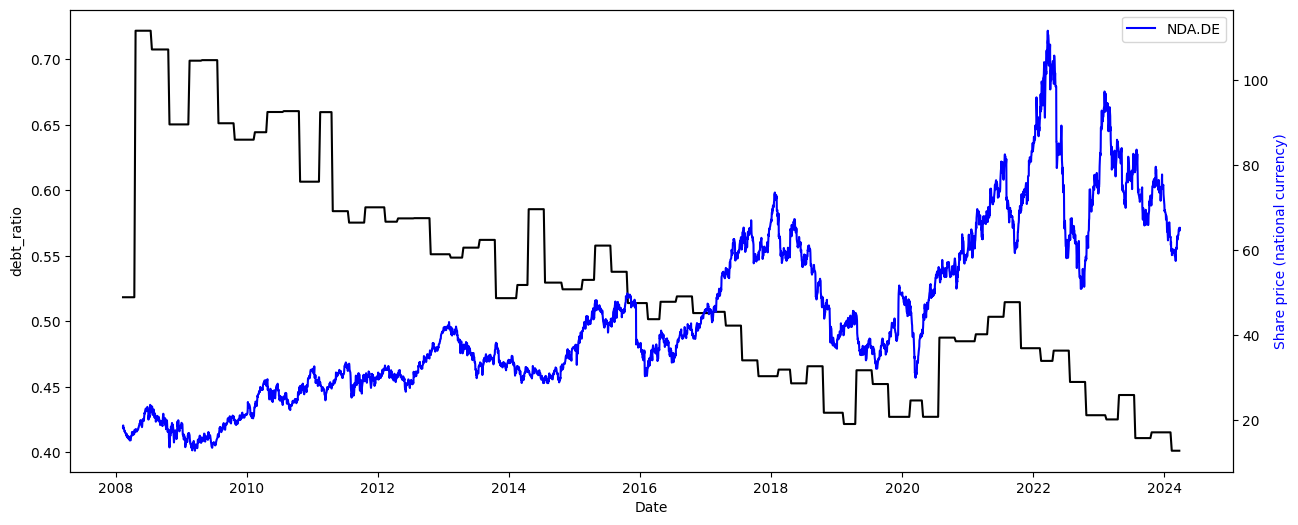

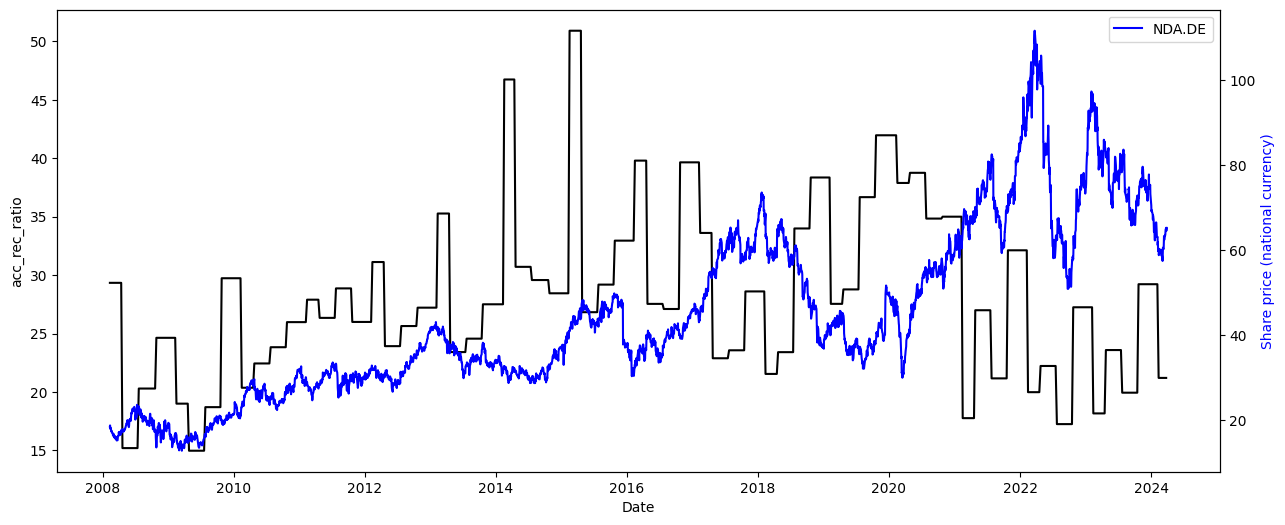

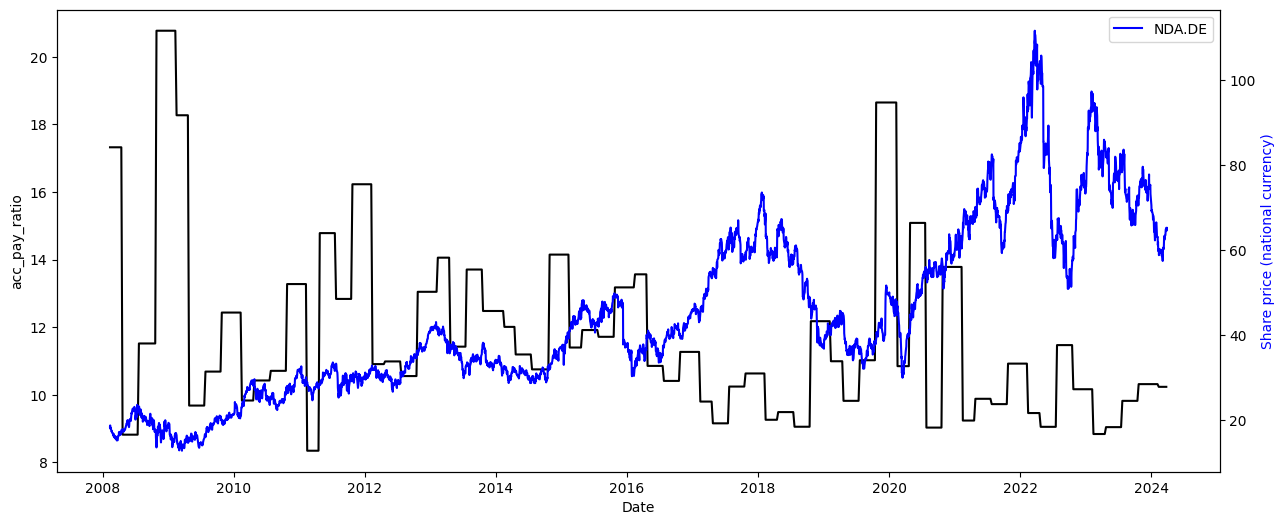

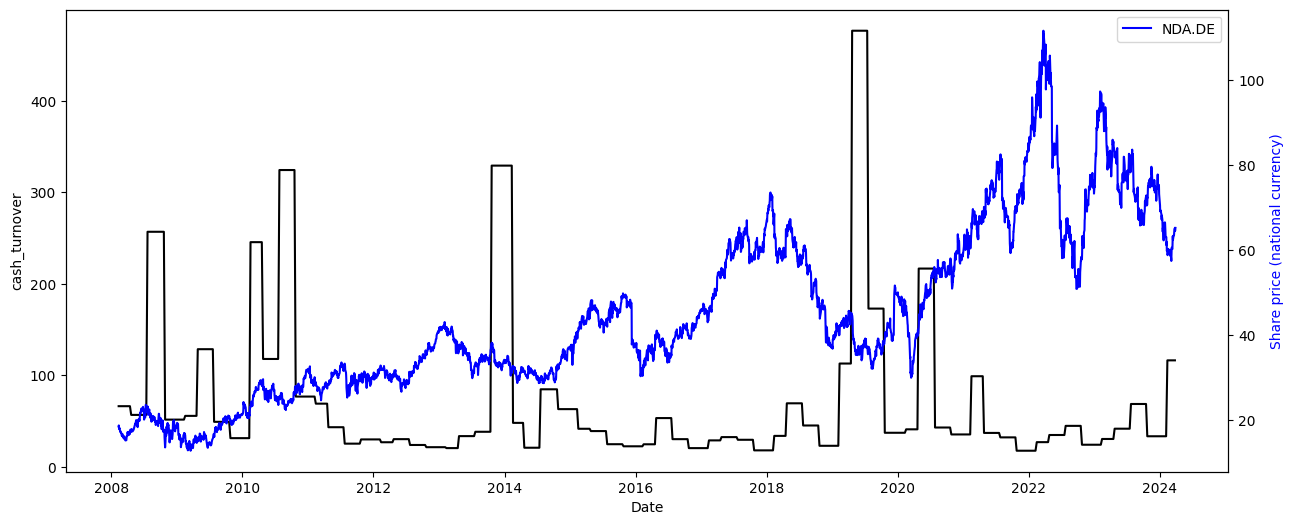

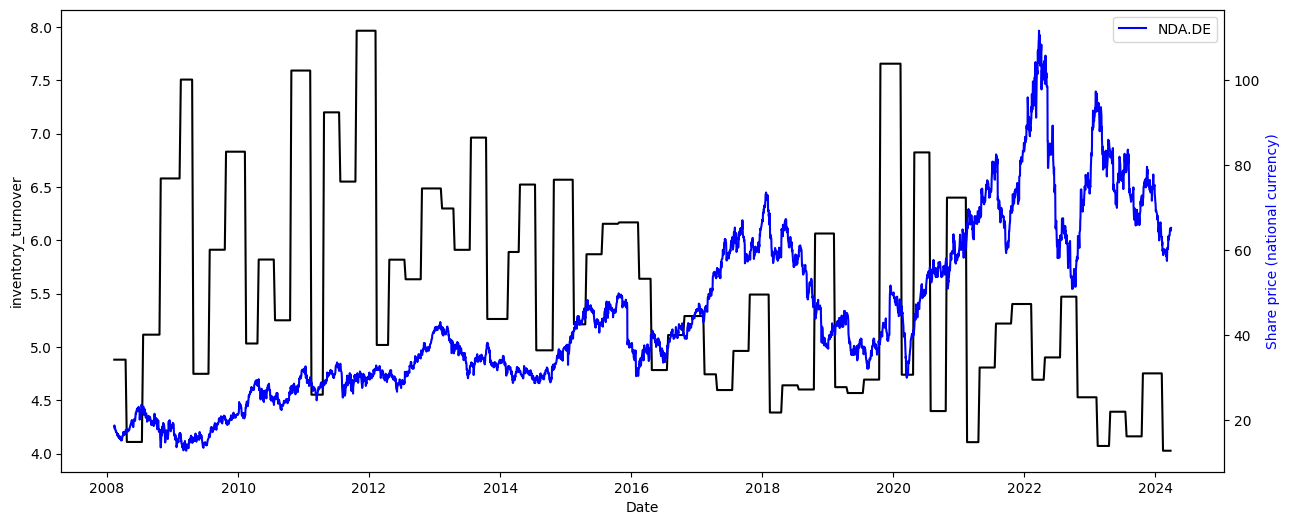

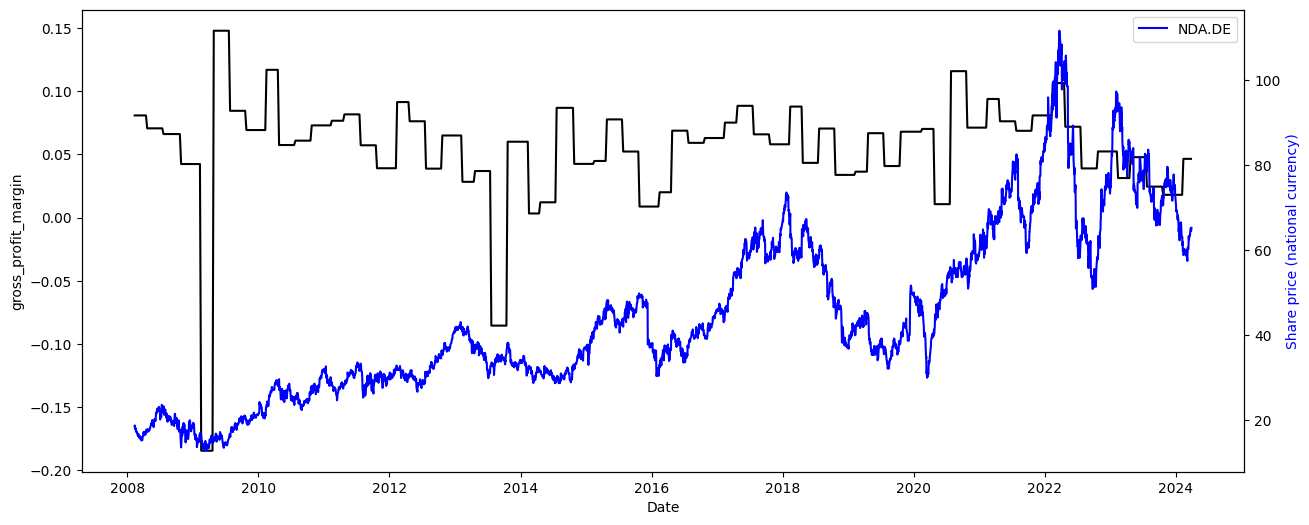

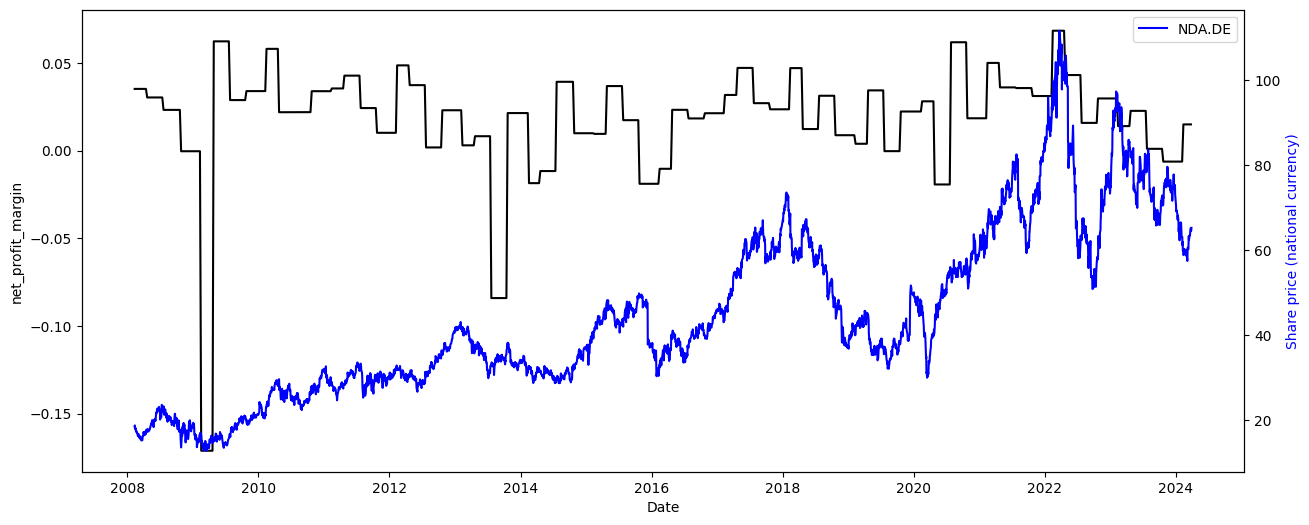

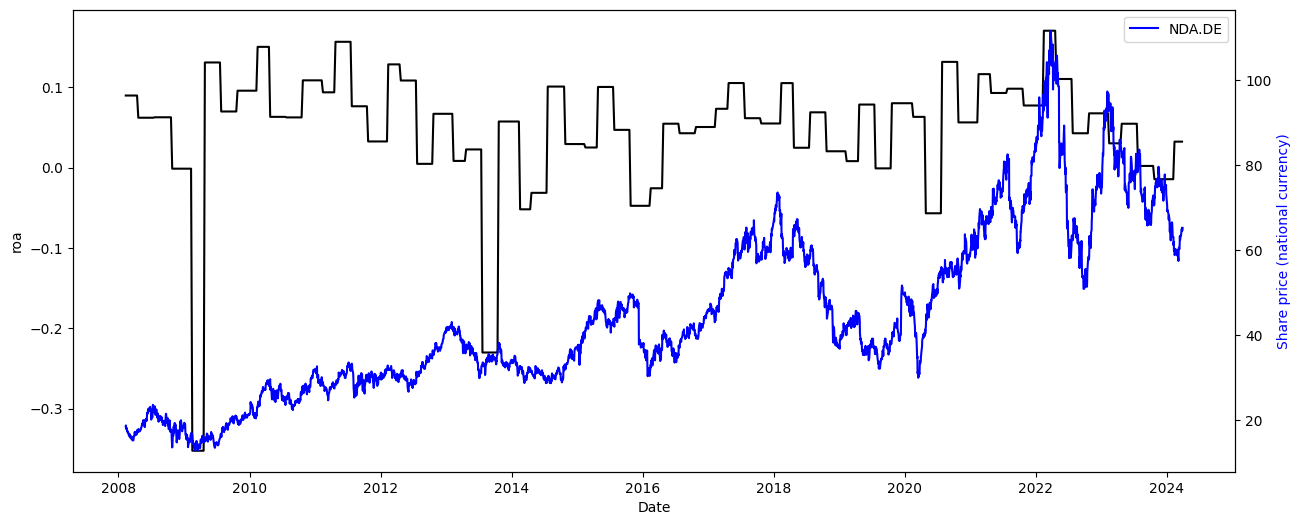

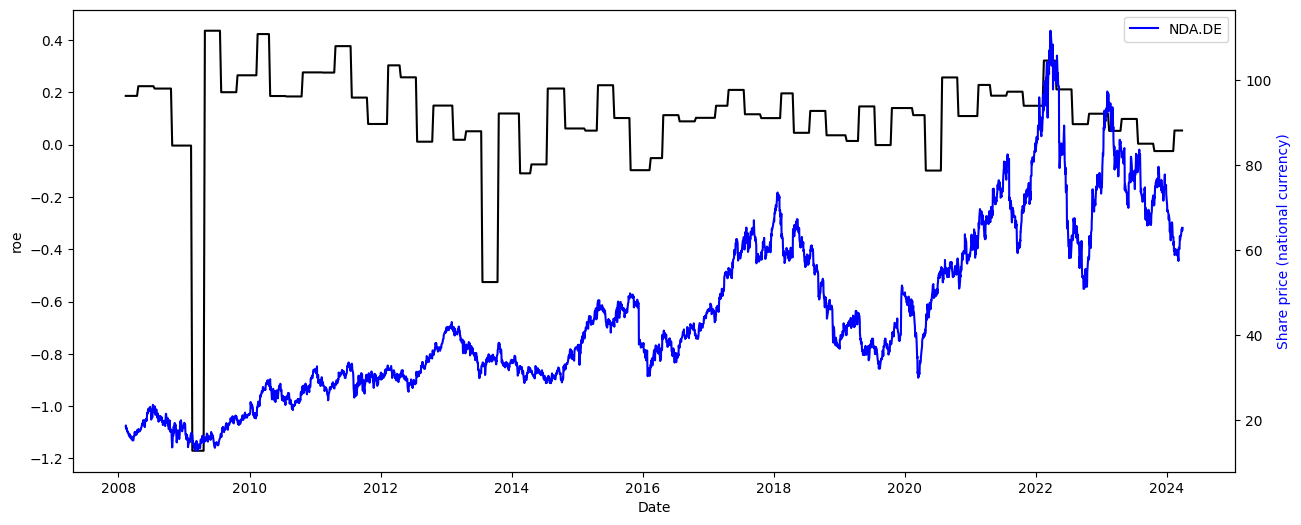

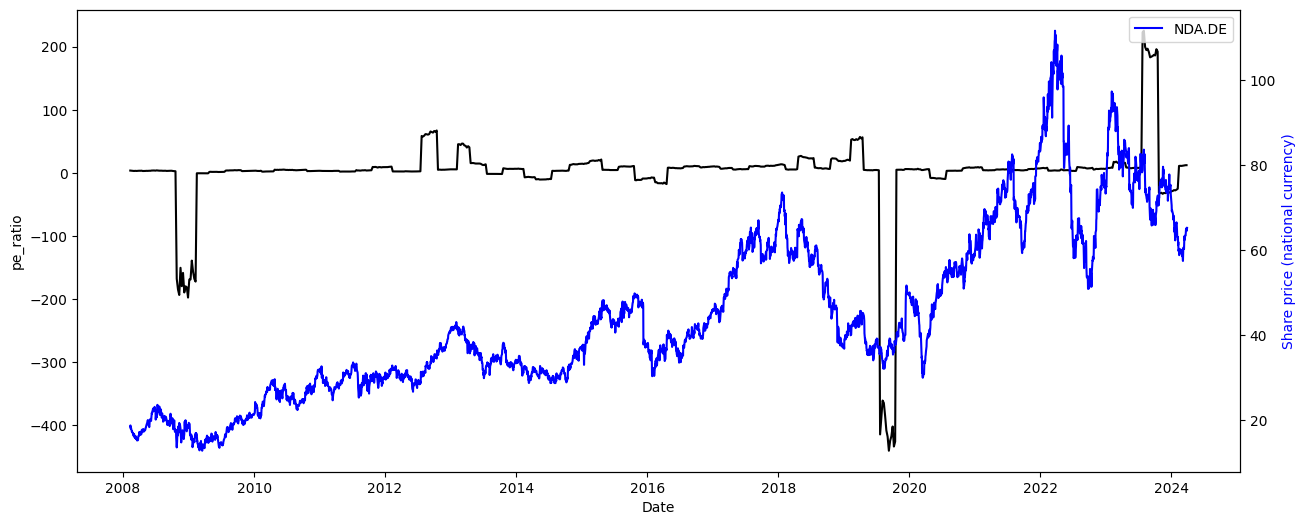

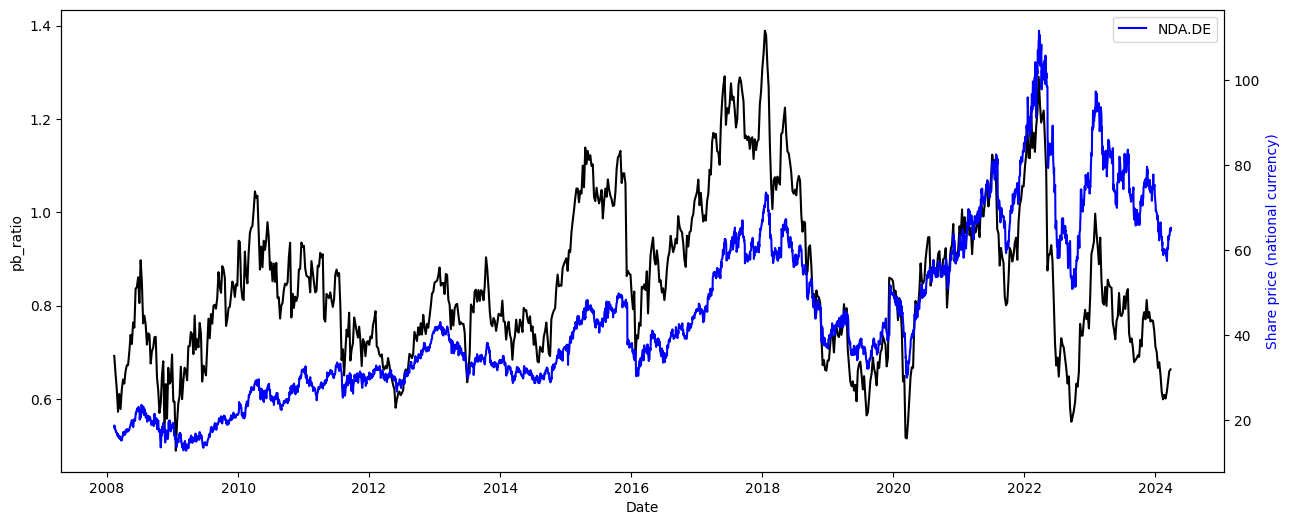

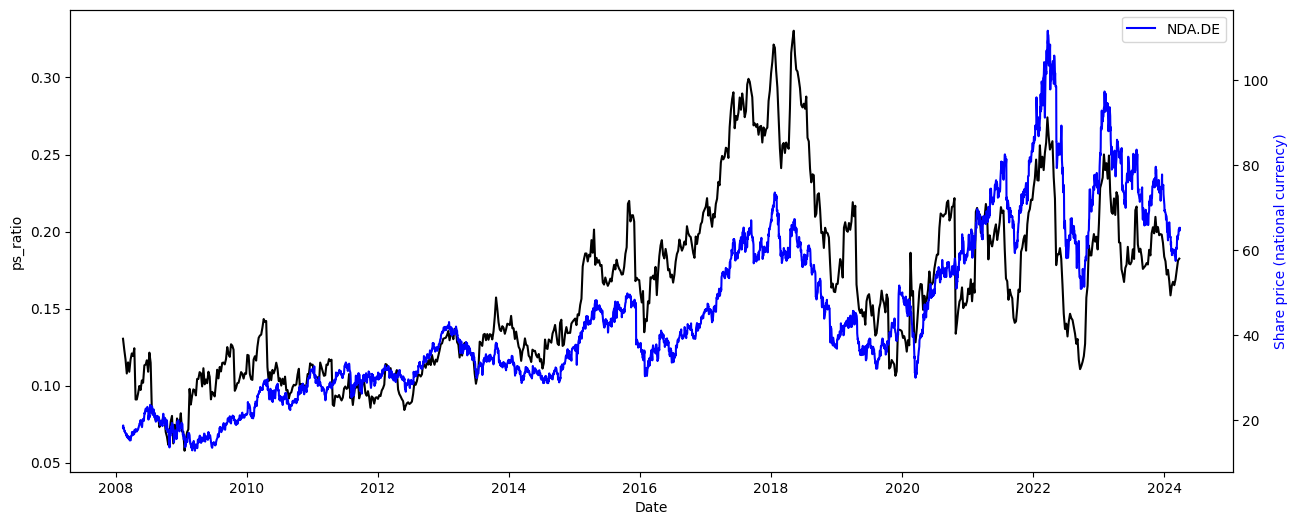

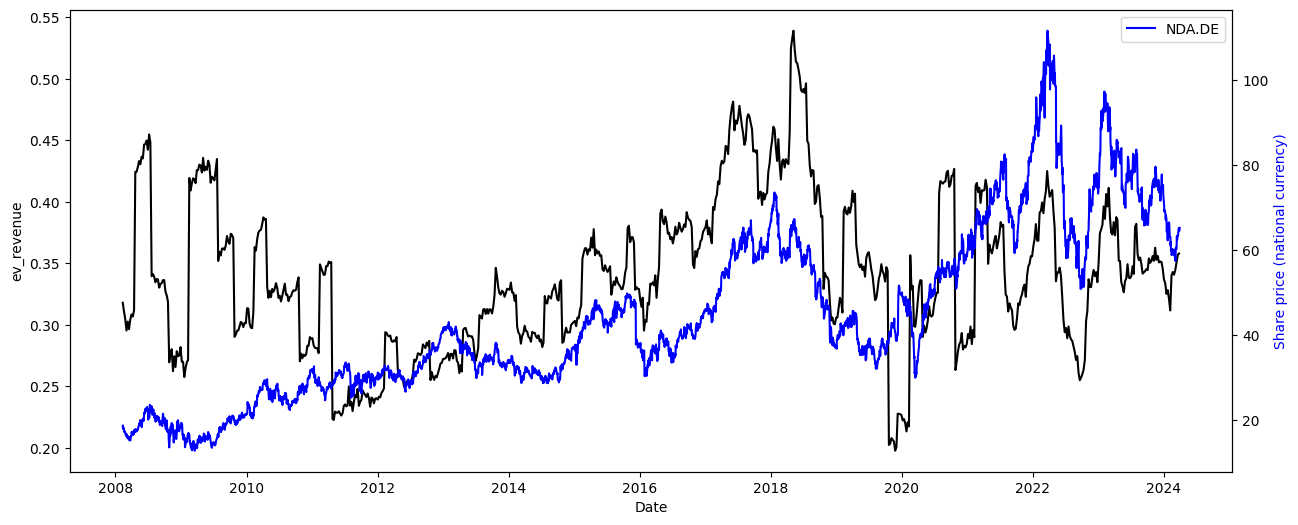

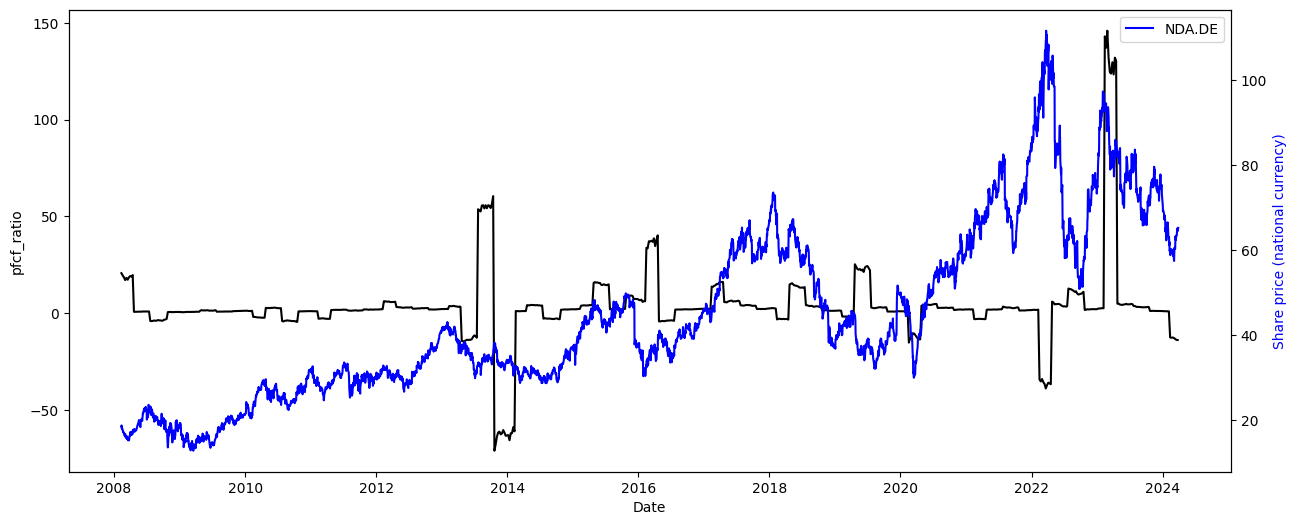

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

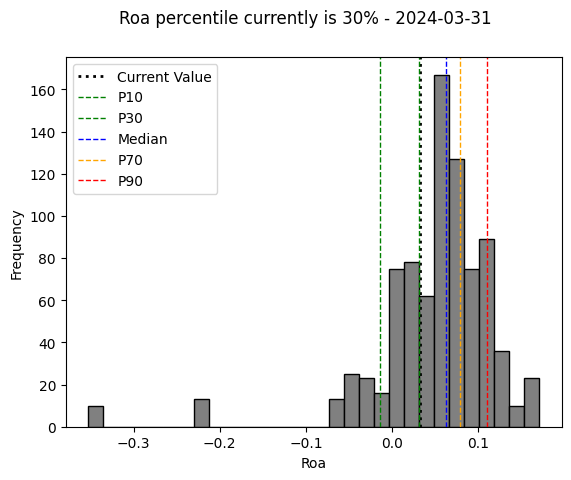

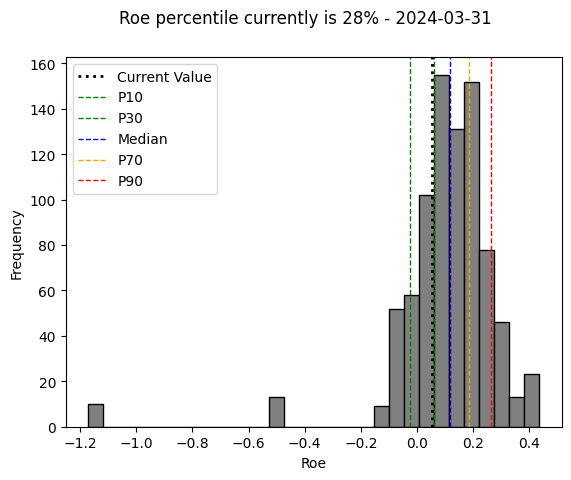

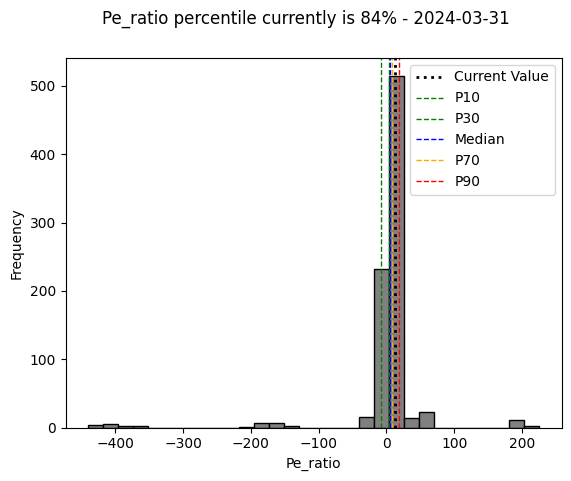

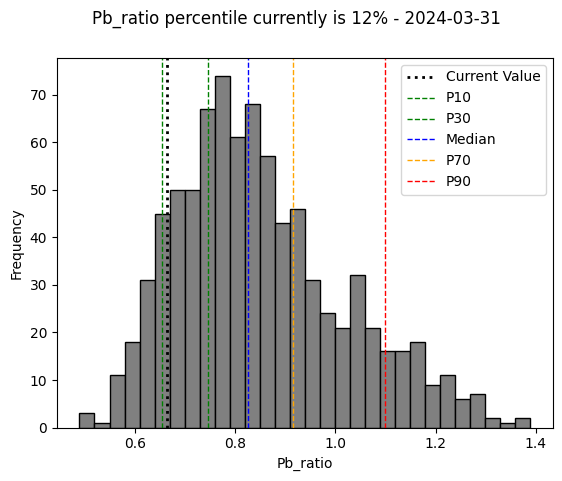

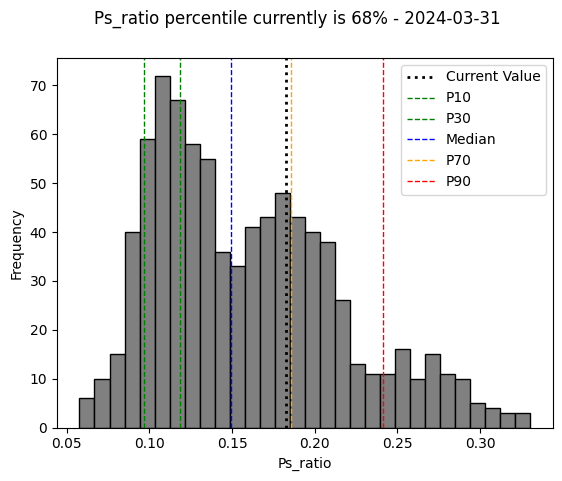

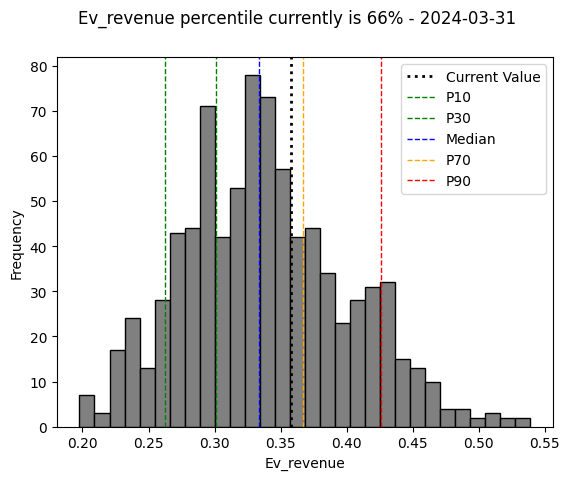

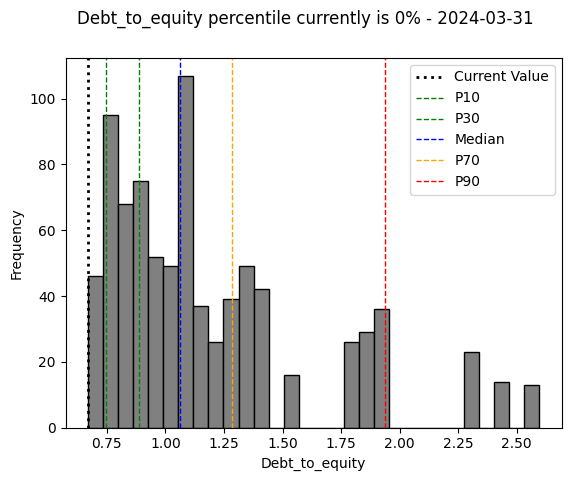

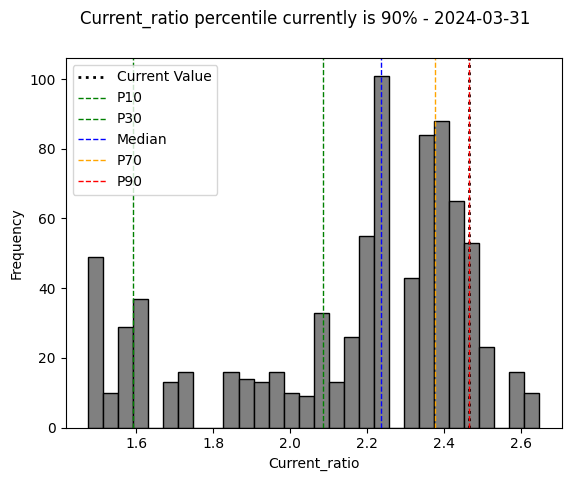

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.972123,0.087020,0.212784,0.097460,0.023129,-0.038359,0.074997
roe,0.972123,1.000000,0.068709,0.163171,0.013952,-0.016125,0.048204,-0.005015
pe_ratio,0.087020,0.068709,1.000000,0.184006,0.146793,0.081733,-0.063794,0.120291
pb_ratio,0.212784,0.163171,0.184006,1.000000,0.755172,0.592540,-0.207831,0.181839
ps_ratio,0.097460,0.013952,0.146793,0.755172,1.000000,0.735527,-0.639406,0.585134
ev_revenue,0.023129,-0.016125,0.081733,0.592540,0.735527,1.000000,-0.049739,0.055892
debt_to_equity,-0.038359,0.048204,-0.063794,-0.207831,-0.639406,-0.049739,1.000000,-0.852032
current_ratio,0.074997,-0.005015,0.120291,0.181839,0.585134,0.055892,-0.852032,1.000000


7 timestemos have been found!


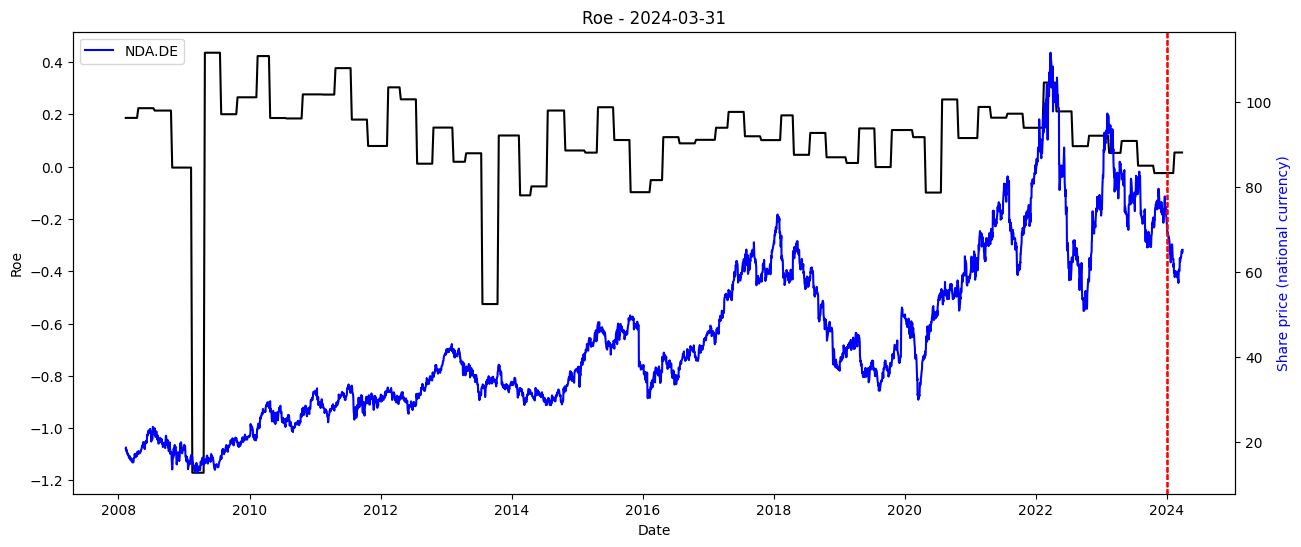

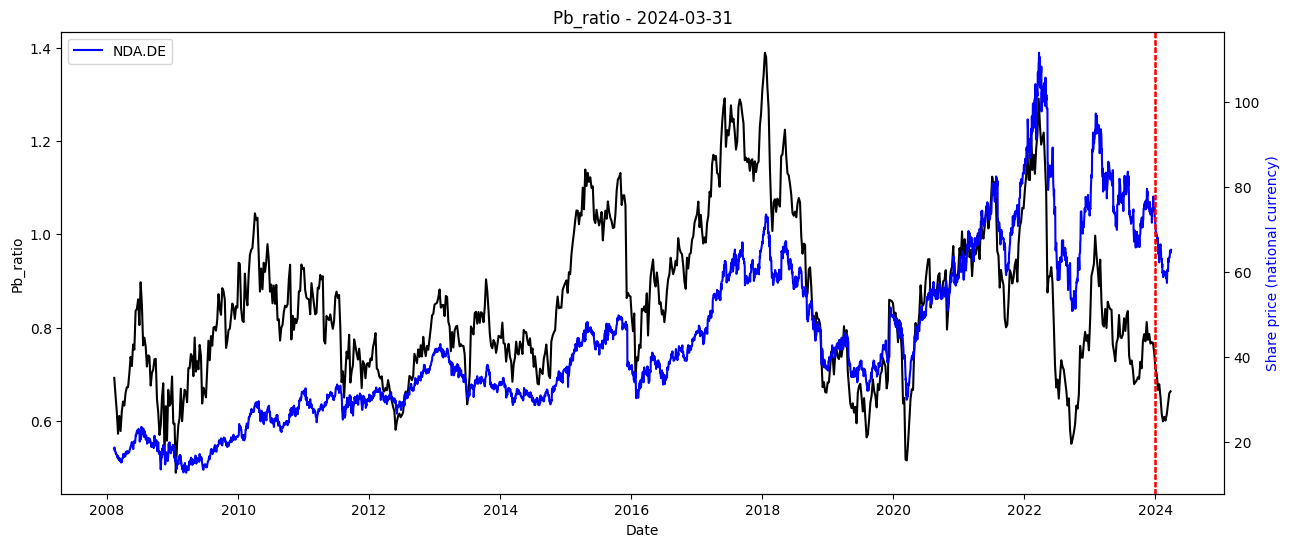

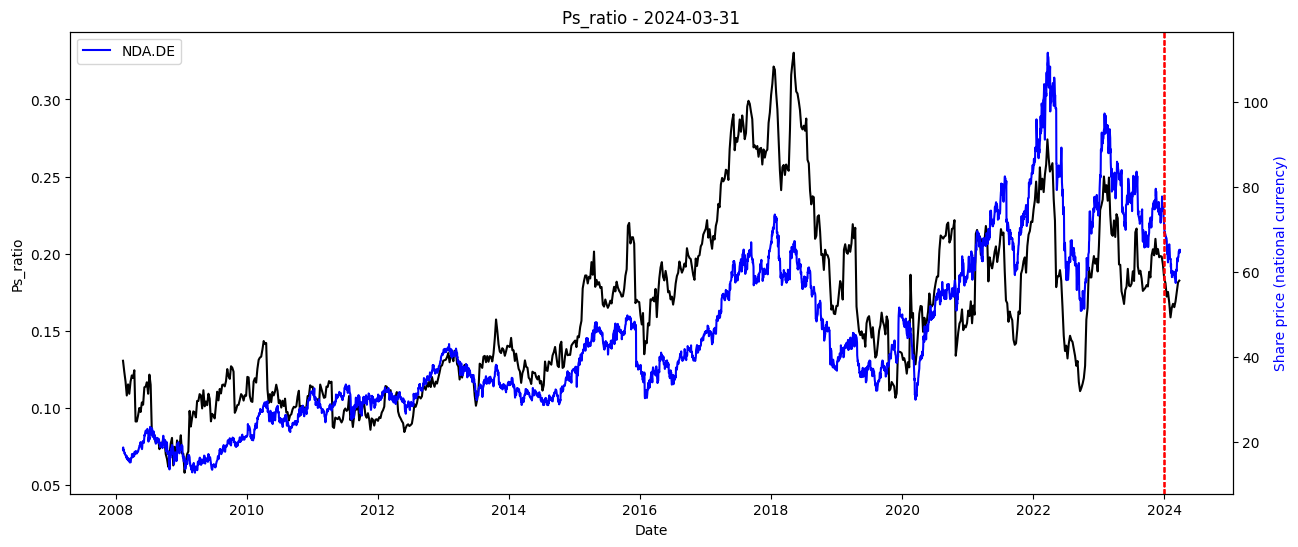

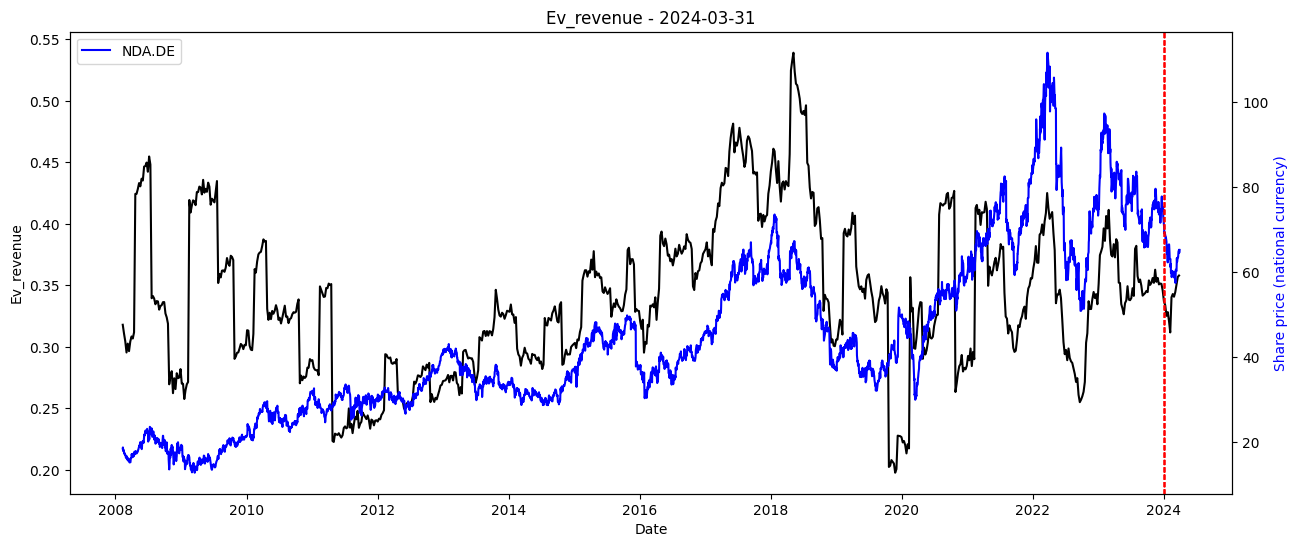

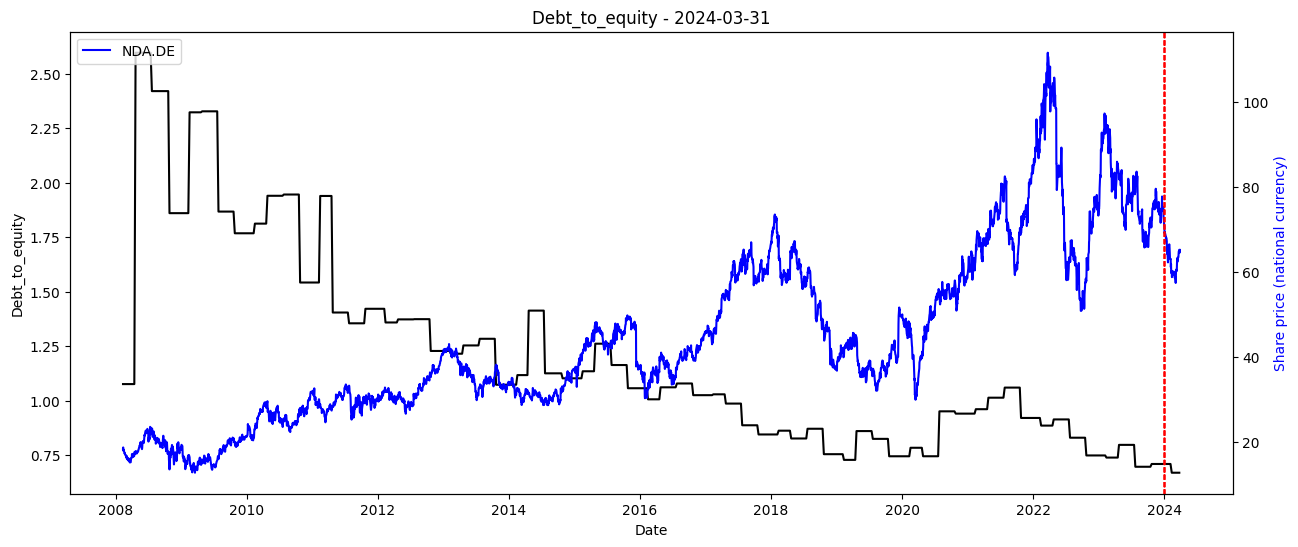

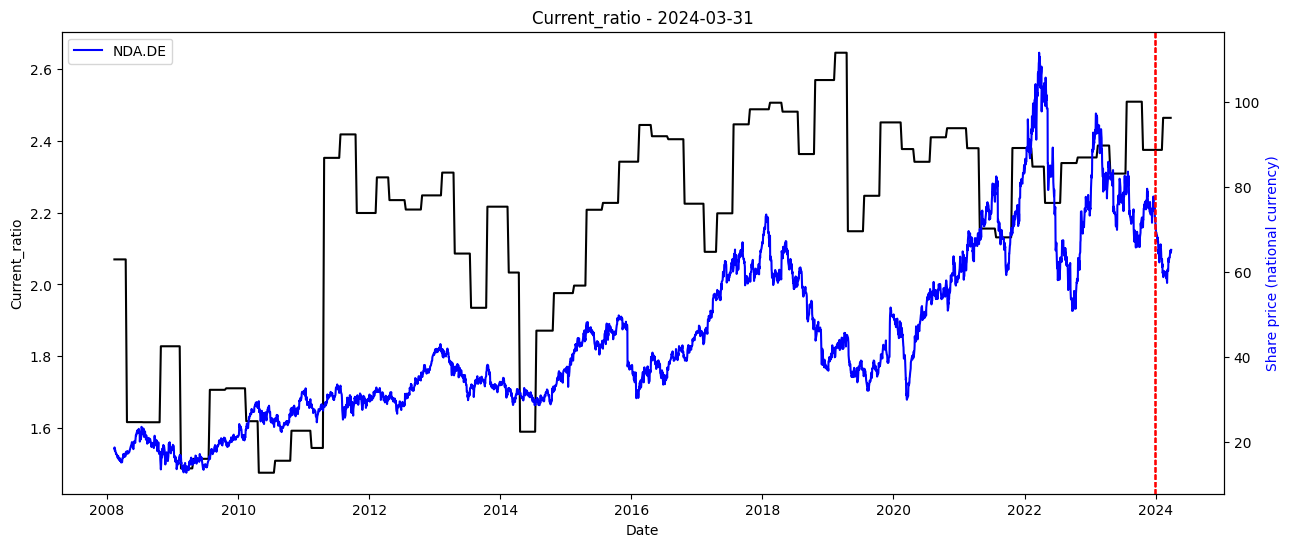

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )